In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
from scipy.sparse import csc_matrix
import time
import warnings

In [42]:
class Params:
    '''
    example: params=Params(g=1,ED=433)
    '''
    def __init__(self,
        a=np.array([1e-10,1e-10,1e-10]), # lattice constant in m
        L=np.array([25e-10,25e-10,50e-10]),   # System size in m
        m=1,    # m_e, where m_e is 0.511 MeV
        E_F=11, # Chemical potential of Al in eV
        E_z=0,  # Zeeman field in eV
        g=10,   # Coupling strength in eV
        E_D=433,    # Debye temperature in K
        T=0,    # Temperature in eV      
        variance=0,     # variance of disorder in eV
        periodic_boundary_condition=1 # 1: periodic boundary condition
        ):
        self.a=np.array(a)*5.076e6    # eV^-1
        self.L=np.array(L)*5.076e6    # eV^-1
        self.m=m*0.511e6    # eV
        self.E_F=E_F        # eV
        self.E_z=E_z        # eV
        self.g=g            # eV
        self.E_D=E_D*8.617333262e-5       # eV
        self.T=T            # eV
        self.variance=variance  # eV
        self.periodic_boundary_condition=periodic_boundary_condition


        self.N=np.rint(self.L/self.a).astype(int)    # Number of grids in the real-sapce mesh
        self.s0=np.array([[1,0],[0,1]])
        self.sx=np.array([[0,1],[1,0]])
        self.sy=np.array([[0,-1j],[1j,0]])
        self.sz=np.array([[1,0],[0,-1]])
        self.b=2*np.pi/self.a    # reciprocal unit vector in eV
        self.t=1/(2*self.m*self.a*self.a)    # NN hopping in eV
        self.disorder=self.variance*np.random.randn(self.N[0],self.N[1])    # disorder profile
        self.Delta=np.zeros((self.N[0],self.N[1]))  
        self.wfall=[[] for _ in range(self.N[2])]
        self.energyall=[[] for _ in range(self.N[2])]    


    def energy_kz(self):
        kindex=np.arange(self.N[2])
        uz=(2*kindex-self.N[2]+1)/(2*self.N[2])
        self.kzlist=uz*self.b[2]    # eV^-1
        self.energylist=2*self.t[2]*(1-np.cos(self.a[2]*self.kzlist))   # eV
        return self.energylist
    
    def estimate_k(self):
        k_request=np.zeros(self.N[2])
        for kzindex in range(self.N[2]):
            kxindex=np.arange(self.N[0])
            kyindex=np.arange(self.N[1])        
            ux=(2*kxindex-self.N[0]+1)/(2*self.N[0])
            uy=(2*kyindex-self.N[1]+1)/(2*self.N[1])
            kxlist=ux*self.b[0]
            kylist=uy*self.b[1]
            kz=self.kzlist[kzindex]
            [kxgrid,kygrid]=np.meshgrid(kxlist,kylist)
            Emesh=2*self.t[0]*(1-np.cos(kxgrid*self.a[0]))\
                +2*self.t[1]*(1-np.cos(kygrid*self.a[1]))\
                +2*self.t[2]*(1-np.cos(kz*self.a[2]))-self.E_F
            k_request[kzindex]=4*np.count_nonzero((Emesh<self.E_D) & (Emesh>-self.E_D))
        self.k_request=k_request.astype(int)
        return self.k_request
    
    def Fermi_dist(self):
        self.F_D=[1./(np.exp(np.array(energy)/self.T)+1) if len(energy)>0 else [] for energy in self.energyall]
        return self.F_D


In [43]:
def make_bare_Al(param,kzindex):
    lat=kwant.lattice.Monatomic(((param.a[0],0),(0,param.a[1])))
    syst= kwant.Builder()
    for x in range(param.N[0]):
        for y in range(param.N[1]):
            syst[lat(x,y)]=(2*param.t[0]+2*param.t[1]+param.energylist[kzindex]-param.E_F+param.disorder[x,y])*np.kron(param.sz,param.s0)+(param.Delta[x,y])*np.kron(param.sy,param.sy)
    syst[kwant.builder.HoppingKind((1, 0), lat, lat)]=-param.t[0]*np.kron(param.sz,param.s0)
    syst[kwant.builder.HoppingKind((0, 1), lat, lat)]=-param.t[1]*np.kron(param.sz,param.s0)
    syst[((lat(0,j),lat(param.N[0]-1,j)) for j in range(param.N[1]))]=-param.t[0]*np.kron(param.sz,param.s0)*param.periodic_boundary_condition
    syst[((lat(j,0),lat(j,param.N[1]-1)) for j in range(param.N[0]))]=-param.t[1]*np.kron(param.sz,param.s0)*param.periodic_boundary_condition
    return syst.finalized()


In [96]:
def energyMF(param):
    '''
    diagonlization of the mean-field Hamiltonian
    '''
    start_time=time.time()
    k_request_nz,=np.where(param.k_request[:param.N[2]//2]!=0)   # take out the nonzero index
    for kindex in k_request_nz:
        # kindex=k_request_nz[k_request_nz_index]        
        k_req=param.k_request[kindex]
        k_req=np.max([40,2*(1.1*k_req//2).astype(int)])
        syst=make_bare_Al(param,kindex)
        H_bdg=syst.hamiltonian_submatrix()
        H_bdg=csc_matrix(np.real((H_bdg+H_bdg.T.conj())/2))
        if len(param.energyall[kindex])>0:
            val,vec=sla.eigsh(H_bdg,k=k_req,sigma=0,v0=param.wfall[kindex][:,0])
        else:
            val,vec=sla.eigsh(H_bdg,k=k_req,sigma=0)
        
        print('kindex={},min(val)={:e},max(val)={:e},'.format(kindex,np.min(np.abs(val)),np.max(np.abs(val))))

        # restart with 2*k_req
        while np.max(val)<param.E_D:
            print('k ({}) is too small, restart with k ({})'.format(k_req,k_req*2))
            k_req=k_req*2
            if len(param.energyall[kindex])>0:
                val,vec=sla.eigsh(H_bdg,k=k_req,sigma=0,v0=param.wfall[kindex][:,0])
            else:
                val,vec=sla.eigsh(H_bdg,k=k_req,sigma=0)
        
        debyeindex=(np.abs(val)<=param.E_D)
        val=val[debyeindex]
        vec=vec[:,debyeindex]

        sortindex=np.argsort(val)
        val=val[sortindex]
        vec=vec[:,sortindex]
        print('len(val)={}'.format(val.shape[0]))

        param.energyall[kindex]=val
        param.energyall[param.N[2]-kindex-1]=val
        param.wfall[kindex]=vec
        param.wfall[param.N[2]-kindex-1]=vec
    print('Elapsed time is: {:.1f}s'.format(time.time()-start_time))

In [45]:
def ave(param):
    '''
    Taking average of 1/2 1/Nz*sum_kz c_{r,-k,down} c_{r,k,up}
    '''
    param.ave=np.zeros((param.N[0]*param.N[1]))
    param.Fermi_dist()    
    for kindex in range(param.N[2]):
        if len(param.energyall[kindex])>0:
            wf=param.wfall[kindex].reshape((param.N[0]*param.N[1],4,-1))
            param.ave+=(wf[:,3,:].conj()*wf[:,0,:]-wf[:,2,:].conj()*wf[:,1,:])@param.F_D[kindex]
    
    param.ave=param.ave/(2*param.N[2])
    param.Delta=param.g*param.ave.reshape((param.N[0],param.N[1]))

In [46]:
def iter(initial,param):
    '''
    Iterations to find self-consistent solution
    '''
    param.Delta=initial*np.ones((param.N[0],param.N[1]))
    Deltalist=[param.Delta]
    energyMF(param)    
    for i in range(1000):
        ave(param)
        print('-'*10+'Iteration: {}, Average Delta: {:e} eV'.format(i,param.Delta.mean())+'-'*10)
        Deltalist+=[param.Delta]
        if np.abs(Deltalist[i].mean()-Deltalist[i-1].mean())<1e-8:
            break
        energyMF(param)

# bilayer

In [107]:
np.kron(params.sy,params.sy)

array([[ 0.+0.j,  0.-0.j,  0.-0.j, -1.+0.j],
       [ 0.+0.j,  0.+0.j,  1.-0.j,  0.-0.j],
       [ 0.+0.j,  1.-0.j,  0.+0.j,  0.-0.j],
       [-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]])

In [108]:
zz={}

In [110]:
zz[1]=1

In [115]:
zz.keys()

dict_keys([1, 'a', (1, 2)])

In [112]:
zz['a']='a'

In [114]:
zz[(1,2)]='b'

In [120]:
class test:
    def __init__(self,U_D):
        self.U_D=U_D
        self.V={}

    def get_V(self,pos):
        try:
            return self.V[pos]
        except:
            self.V[pos]=np.random.uniform(-self.U_D,self.U_D)
            return self.V[pos]

    



In [121]:
tt=test(1)

In [124]:
tt.V

{(0, 0): 0.6276805517926551}

In [126]:
tt.get_V((0,0))

0.6276805517926551

In [31]:
np.rint(params.L_Al/params.a)-100

array([  0.,   0., -50.])

In [144]:
class Params:
    '''
    generate bilayer hetereostructure
    example: params=Params(g=1,ED=433)
    
    '''
    def __init__(self,
        a=np.array([0.1,0.1,0.1]), # lattice constant (nm)
        L_Al=np.array([10,10,5]),   # size of Al (nm)
        L_FM=np.array([2,10,5]), # size of FM (nm)
        m_Al=1,    # effective mass in Al in m_e, where m_e is 0.511 MeV
        m_FM=0.3,   # effective mass in FM in  m_e, where m_e is 0.511 MeV
        EF_Al=11, # Chemical potential of Al in eV
        EF_FM=-0.5,
        h_exc=0,  # exchange field in eV, acts like Zeeman field
        g=5.6,   # Coupling strength in eV
        E_D=1,    # Debye temperature in 433 K
        T=0,    # Temperature in eV      
        U_D=0,     # variance of disorder in eV
        Delta_0=3.5e-4,    # the initial SC gap
        periodic_boundary_condition=1, # 1: periodic boundary condition
        verbose=True,   #verbose
        store_history=False
        ):
        assert L_Al[1]==L_FM[1] and L_Al[2]==L_FM[2],"The y,z dimension of Al ({},{}) not same as FM ({},{})".format(L_Al[1],L_Al[2],L_FM[1],L_FM[2])
        self.a=np.array(a)*1e-9*5.076e6    # eV^-1
        self.L_Al=np.array(L_Al)*1e-9*5.076e6    # eV^-1
        self.L_FM=np.array(L_FM)*1e-9*5.076e6   # eV^-1
        self.m_Al=m_Al*0.511e6    # eV
        self.m_FM=m_FM*0.511e6    # eV
        self.EF_Al=EF_Al        # eV
        self.EF_FM=EF_FM        # eV
        self.h_exc=h_exc        # eV
        self.g=g            # eV
        self.E_D=E_D*433*8.617333262e-5       # eV
        self.T=T            # eV
        self.U_D=U_D  # eV
        self.Delta_0=Delta_0    #initial value of SC gap
        self.periodic_boundary_condition=periodic_boundary_condition
        self.verbose=verbose


        self.N_Al=np.rint(self.L_Al/self.a).astype(int)    # dimension of sites in Al
        self.N_FM=np.rint(self.L_FM/self.a).astype(int)    # dimension of sites in FM
        self.s0=np.array([[1,0],[0,1]])
        self.sx=np.array([[0,1],[1,0]])
        self.sy=np.array([[0,-1j],[1j,0]])
        self.sz=np.array([[1,0],[0,-1]])
        self.b=2*np.pi/self.a    # reciprocal unit vector in eV
        self.t_Al=1/(2*self.m_Al*self.a**2)    # NN hopping of Al in eV
        self.t_FM=1/(2*self.m_FM*self.a**2)    # NN hopping of FM in eV
        self.m_int=np.sqrt(self.m_Al*self.m_FM)
        self.t_int=1/(2*self.m_int*self.a**2)    # NN hopping at the interface in eV

        self.disorder={}    # generate empty dict for disorder profile
        self.Delta={}
        self.Delta_array=[]
        # self.Delta=np.zeros((self.N[0],self.N[1]))  
        # self.wfall=[[] for _ in range(self.N[2])]
        # self.energyall=[[] for _ in range(self.N[2])]    
        self.wfall=[]
        self.energyall=[]
        self.store_history=store_history
        if store_history:
            self.wfall_history=[]
            self.energyall_history=[]

        self.make_system()
        self.generate_disorder()
        self.update_Delta()
        self.energy_kz()
        self.estimate_eig()



    def energy_kz(self):
        kindex=np.arange(self.N_Al[2])
        uz=(2*kindex-self.N_Al[2]+1)/(2*self.N_Al[2])
        self.kz_list=uz*self.b[2]    # eV^-1
        self.energy_Al=2*self.t_Al[2]*(1-np.cos(self.a[2]*self.kz_list))   # bandstructure of Al
        self.energy_FM=2*self.t_FM[2]*(1-np.cos(self.a[2]*self.kz_list))   # bandstructure of Al

    
    def estimate_eig(self):
        k_list={}
        for i in range(2):
            k_list[i]=(2*np.arange(self.N_Al[i])-self.N_Al[i]+1)/(2*self.N_Al[i])*self.b[i]
        [kx_grid,ky_grid]=np.meshgrid(k_list[0],k_list[1])
        self.estimate=[]
        for kz in self.kz_list:
            E_mesh=2*self.t_Al[0]*(1-np.cos(kx_grid*self.a[0]))+2*self.t_Al[1]*(1-np.cos(ky_grid*self.a[1]))+2*self.t_Al[2]*(1-np.cos(kz*self.a[2]))-self.EF_Al
            self.estimate.append(4*np.count_nonzero((E_mesh<self.E_D)*(E_mesh>-self.E_D)))        
        self.estimate=np.array(self.estimate)
        
    def Fermi_dist(self):
        if self.T==0:
            self.F_D=[np.heaviside(-energy,0) if len(energy)>0 else [] for energy in self.energyall]
        else:
            self.F_D=[1./(np.exp(np.array(energy)/self.T)+1) if len(energy)>0 else [] for energy in self.energyall]

    def get_disorder(self,pos):
        try:
            return self.disorder[pos]
        except:
            self.disorder[pos]=np.random.uniform(-self.U_D,self.U_D)
            return self.disorder[pos]

    def generate_disorder(self):
        if len(self.disorder)==0:
            for site in self.system.sites:
                self.disorder[site.pos]=np.random.uniform(-self.U_D,self.U_D)
        else:
            raise ValueError("Disorder is already generated")

    def update_Delta(self):
        if len(self.Delta_array)==0:
            for site in self.system.sites:
                self.Delta[site.pos]=self.Delta_0
        else:
            for site_index,site in enumerate(self.system.sites):
                self.Delta[site.pos]=self.Delta_array[site_index]
        
        self.Delta_mean=np.mean([delta for position,delta in self.Delta.items() if position[0]>0])
                
    def make_system(self):
        def shape(pos):
            x,y=pos
            in_x=-self.L_FM[0]<=x<=self.L_Al[0]
            in_y=0<=y<=self.L_Al[1]
            return in_x and in_y
        
        def onsite(site,kz_index):
            x,y=site.pos
            if x>self.a[0]:
                return (2*self.t_Al[0]+2*self.t_Al[1]+self.energy_Al[kz_index]-self.EF_Al+self.disorder[site.pos])*np.kron(self.sz,self.s0)+self.Delta[site.pos]*np.kron(self.sy,self.sy)
            elif x>0:
                return (self.t_Al[0]+self.t_int[0]+2*self.t_Al[1]+self.energy_Al[kz_index]-self.EF_Al+self.disorder[site.pos])*np.kron(self.sz,self.s0)+self.Delta[site.pos]*np.kron(self.sy,self.sy)
            elif x>-self.a[0]:
                return (self.t_FM[0]+self.t_int[0]+2*self.t_FM[1]+self.energy_FM[kz_index]-self.EF_FM)*np.kron(self.sz,self.s0)+self.h_exc*np.kron(self.sz,self.sz)
            else:
                return (2*self.t_FM[0]+2*self.t_FM[1]+self.energy_FM[kz_index]-self.EF_FM)*np.kron(self.sz,self.s0)+self.h_exc*np.kron(self.sz,self.sz)

        def hopping_x(site1,site2):
            x1,y1=site1.pos
            x2,y2=site2.pos
            if (x1+x2)/2>self.a[0]:
                return -self.t_Al[0]*np.kron(self.sz,self.s0)
            if (x1+x2)/2<0:
                return -self.t_FM[0]*np.kron(self.sz,self.s0)
            if 0<(x1+x2)/2<self.a[0]:
                return -self.t_int[0]*np.kron(self.sz,self.s0)
            raise ValueError("The hopping in x dimension between ({},{}) and ({},{}) is not defined".format(x1,y1,x2,y2))


        def hopping_y(site1,site2):
            x1,y1=site1.pos
            x2,y2=site2.pos
            if (x1+x2)/2>0:
                return -self.t_Al[1]*np.kron(self.sz,self.s0)
            if (x1+x2)/2<self.a[0]:
                return -self.t_FM[1]*np.kron(self.sz,self.s0)
            raise ValueError("The hopping in y dimension between ({},{}) and ({},{}) is not defined".format(x1,y1,x2,y2))


        lat=kwant.lattice.Monatomic(((self.a[0],0),(0,self.a[1])))
        syst=kwant.Builder()
        syst[lat.shape(shape,(0,0))]=onsite
        syst[kwant.builder.HoppingKind((1, 0), lat, lat)]=hopping_x
        syst[kwant.builder.HoppingKind((0, 1), lat, lat)]=hopping_y
        self.system=syst.finalized()
        return self.system

    def energyMF(self):
        start_time=time.time()
        k_req_max=np.maximum(self.estimate[:self.N_Al[2]//2],20)
        for kz_index,k_req in enumerate(k_req_max):
            k_req=np.max([40,2*(1.1*k_req//2).astype(int)])
            self.make_system()
            H_bdg=self.system.hamiltonian_submatrix(params=dict(kz_index=kz_index),sparse=True)
            H_bdg=csc_matrix(np.real((H_bdg+H_bdg.T.conj())/2))
            try:
                val,vec=sla.eigsh(H_bdg,k=k_req,sigma=0,v0=self.wfall[kz_index][:,0])
            except:
                val,vec=sla.eigsh(H_bdg,k=k_req,sigma=0)

            print('kz_index={},min(val)={:e},max(val)={:e},'.format(kz_index,np.min(np.abs(val)),np.max(np.abs(val))))
            while np.max(val)<self.E_D:
                print('k_req ({}) is too small, restart with k_req ({})'.format(k_req,k_req*2))
                k_req=k_req*2
                try:
                    val,vec=sla.eigsh(H_bdg,k=k_req,sigma=0,v0=self.wfall[kz_index][:,0])
                except:
                    val,vec=sla.eigsh(H_bdg,k=k_req,sigma=0)

            debyeindex=(np.abs(val)<=self.E_D)
            val=val[debyeindex]
            vec=vec[:,debyeindex]
            sort_index=np.argsort(val)
            val=val[sort_index]
            vec=vec[:,sort_index]
            print('len(val)={}'.format(val.shape[0]))

            self.energyall.append(val)
            self.wfall.append(vec)

        if self.store_history:
            self.energyall_history.append(self.energyall)
            self.wfall_history.append(self.wfall)
        print('Elapsed time is: {:.1f}s'.format(time.time()-start_time))

    def ave(self):
        self.Fermi_dist()
        summation=[]
        # Here only half of k_z is considered because E(kz) is even
        for kz_index,energy in enumerate(self.energyall):
            if len(energy)>0:
                wf=self.wfall[kz_index].reshape((len(self.system.sites),4,-1))
                summation.append((wf[:,3,:].conj()*wf[:,0,:]-wf[:,2,:].conj()*wf[:,1,:])@self.F_D[kz_index])

        ave=np.mean(summation,0)/(2)    
        self.Delta_array=self.g*ave
        self.update_Delta()



In [147]:
def run():
    params=Params(L_Al=np.array([10,10,10])/2,L_FM=np.array([2,10,10])/2,U_D=0)
    Delta_mean_list=[params.Delta_mean]
    params.energyMF()
    for i in range(1000):
        params.ave()
        print('-'*10+'Iteration: {}, Average Delta: {:e} eV'.format(i,params.Delta_mean)+'-'*10)
        Delta_mean_list.append(params.Delta_mean)
        if np.abs(Delta_mean_list[-1]-Delta_mean_list[-2])<1e-8:
            break
        params.energyMF()


In [148]:
run()

kz_index=0,min(val)=4.204923e+00,max(val)=4.432016e+00,
len(val)=0
kz_index=1,min(val)=4.085379e+00,max(val)=4.312469e+00,
len(val)=0
kz_index=2,min(val)=3.848177e+00,max(val)=4.075260e+00,
len(val)=0
kz_index=3,min(val)=3.497057e+00,max(val)=3.724131e+00,
len(val)=0
kz_index=4,min(val)=3.037556e+00,max(val)=3.264618e+00,
len(val)=0
kz_index=5,min(val)=2.476922e+00,max(val)=2.703967e+00,
len(val)=0
kz_index=6,min(val)=1.823996e+00,max(val)=2.051021e+00,
len(val)=0
kz_index=7,min(val)=1.089074e+00,max(val)=1.316075e+00,
len(val)=0
kz_index=8,min(val)=2.837478e-01,max(val)=5.107190e-01,
len(val)=0
kz_index=9,min(val)=2.305496e-03,max(val)=1.023610e-01,
len(val)=16
kz_index=10,min(val)=1.227342e-03,max(val)=8.746880e-02,
len(val)=16
kz_index=11,min(val)=8.495364e-03,max(val)=9.345235e-02,
len(val)=20
kz_index=12,min(val)=5.450413e-03,max(val)=7.967229e-02,
len(val)=16
kz_index=13,min(val)=3.988160e-03,max(val)=8.630003e-02,
len(val)=16
kz_index=14,min(val)=1.933398e-02,max(val)=8.556742e-

In [137]:
params=Params(L_Al=np.array([10,10,10])/1,L_FM=np.array([2,10,10])/1,U_D=0)
# params.energyMF()

In [138]:
params.Delta_mean

0.0003499999999999999

In [124]:
def ave2(self):
    self.Fermi_dist()
    summation=[]
    # Here only half of k_z is considered because E(kz) is even
    for kz_index,energy in enumerate(self.energyall):
        if len(energy)>0:
            # wf=self.wfall[kz_index].reshape((4,len(self.system.sites),-1))
            # summation.append((wf[3,:,:].conj()*wf[0,:,:]-wf[2,:,:].conj()*wf[1,:,:])@self.F_D[kz_index])
            wf=self.wfall[kz_index].reshape((len(self.system.sites),4,-1))
            summation.append((wf[:,3,:].conj()*wf[:,0,:]-wf[:,2,:].conj()*wf[:,1,:])@self.F_D[kz_index])

    ave=np.mean(summation,0)/(2)    
    self.Delta_array=self.g*ave
    self.update_Delta()

In [128]:
def update_Delta(self):
        if len(self.Delta_array)==0:
            for site in self.system.sites:
                self.Delta[site.pos]=self.Delta_0
        else:
            for site_index,site in enumerate(self.system.sites):
                self.Delta[site.pos]=self.Delta_array[site_index]
        
        self.Delta_mean=np.mean([delta for position,delta in self.Delta.items() if position[0]>0])

In [129]:
update_Delta(params)

In [130]:
params.Delta_mean

0.00034445704922788305

In [125]:
ave2(params)

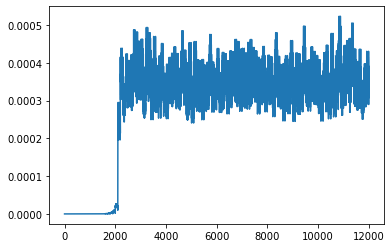

In [126]:
plt.plot(params.Delta_array)

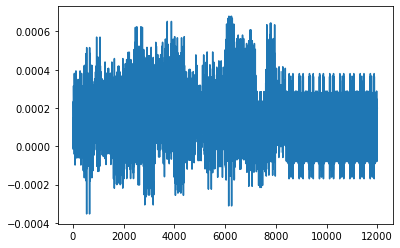

In [117]:
plt.plot(params.Delta_array)

In [68]:
params.estimate_eig()

In [80]:
len(params.system.sites)

12000

In [74]:
zz,=np.where(params.estimate[:params.N_Al[2]//2]!=0)

In [63]:
np.maximum(params.estimate[:params.N_Al[2]//2],20)

array([ 20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
        20,  20,  20,  20,  20,  48,  96,  80,  64,  96,  96,  48,  64,
        96, 128, 128,  96,  96,  96,  64,  96,  96,  32, 128, 160,  96,
        96,  96,  32, 192, 128, 160,  96,  96,  64, 112, 192])

In [78]:
np.maximum(params.estimate[:params.N_Al[2]//2],20)

array([ 20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
        20,  20,  20,  20,  20,  48,  96,  80,  64,  96,  96,  48,  64,
        96, 128, 128,  96,  96,  96,  64,  96,  96,  32, 128, 160,  96,
        96,  96,  32, 192, 128, 160,  96,  96,  64, 112, 192])

In [ ]:
params.estimate[:params.N_Al[2]//2]

In [47]:
zz

array([0])

In [43]:
params.L_Al//params.a

array([99., 99., 99.])

In [38]:
len(params.estimate)

100

In [26]:
len(list(params.disorder.values()))

12000

In [27]:
len(list(params.Delta.values()))

12000

In [71]:
params.system.hamiltonian(0,0,params=dict(kz_index=1))

array([[ 101.65619584,    0.        ,    0.        ,    0.        ],
       [   0.        ,  101.65619584,    0.        ,    0.        ],
       [   0.        ,    0.        , -101.65619584,    0.        ],
       [   0.        ,    0.        ,    0.        , -101.65619584]])

In [ ]:
?params.system.hamiltonian

In [ ]:
?params.system.hamiltonian_submatrix

In [81]:
zz=params.system.hamiltonian_submatrix(params=dict(kz_index=1),sparse=True)

In [83]:
zz.shape

(48000, 48000)

In [73]:
zz=params.system.hamiltonian_submatrix(params=dict(kz_index=0),sparse=True)

In [18]:
zz.shape

(48000, 48000)

In [32]:
val,vec=sla.eigsh(zz,k=22,sigma=0)

In [35]:
(val)

array([-4.19398615,  4.20531291,  4.20500431,  4.19398615,  4.19398615,
       -4.19398615, -4.20500431, -4.20531291, -4.20500431, -4.20531291,
        4.20531291,  4.20500431,  4.21633107, -4.21633107,  4.21633107,
       -4.21633107, -4.22335607, -4.22417828, -4.22335607, -4.22417828,
        4.22335607,  4.22335607])

In [10]:
dir(params.system)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_cons_law',
 '_init_discrete_symmetries',
 '_symmetries',
 'discrete_symmetry',
 'graph',
 'hamiltonian',
 'hamiltonian_submatrix',
 'hoppings',
 'id_by_site',
 'lead_interfaces',
 'lead_paddings',
 'leads',
 'onsites',
 'parameters',
 'pos',
 'precalculate',
 'site_ranges',
 'sites',
 'symmetry',
 'validate_symmetries']

In [5]:
zz.shape

(2100, 2100)

In [263]:
params.system.pos(200)

array([0.0025380000000000003, 0.005583600000000001])

In [255]:
params.a

array([0.0005076, 0.0005076, 0.0005076])

In [284]:
params.system.hamiltonian(201,201,params=dict(fill_Delta=1))

array([[ 1.87303892e+01+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        -3.50000000e-04+0.j],
       [ 0.00000000e+00+0.j,  1.87303892e+01+0.j,  3.50000000e-04+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  3.50000000e-04+0.j, -1.87303892e+01+0.j,
         0.00000000e+00+0.j],
       [-3.50000000e-04+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        -1.87303892e+01+0.j]])

In [285]:
i=201
zz[i*4:i*4+4,i*4:i*4+4]

array([[ 1.87303892e+01+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        -3.50000000e-04+0.j],
       [ 0.00000000e+00+0.j,  1.87303892e+01+0.j,  3.50000000e-04+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  3.50000000e-04+0.j, -1.87303892e+01+0.j,
         0.00000000e+00+0.j],
       [-3.50000000e-04+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        -1.87303892e+01+0.j]])

In [266]:
params.system.hamiltonian(202,202,params=dict(fill_Delta=1))

array([[ 1.92870575e+01+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        -3.50000000e-04+0.j],
       [ 0.00000000e+00+0.j,  1.92870575e+01+0.j,  3.50000000e-04+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  3.50000000e-04+0.j, -1.92870575e+01+0.j,
         0.00000000e+00+0.j],
       [-3.50000000e-04+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        -1.92870575e+01+0.j]])

In [145]:
len(params.system.sites)

525

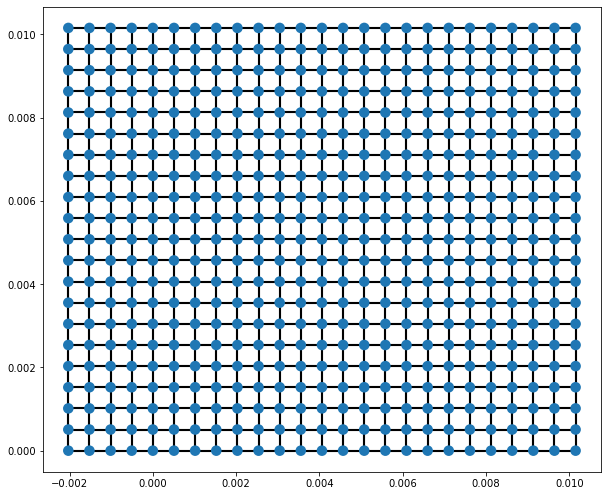

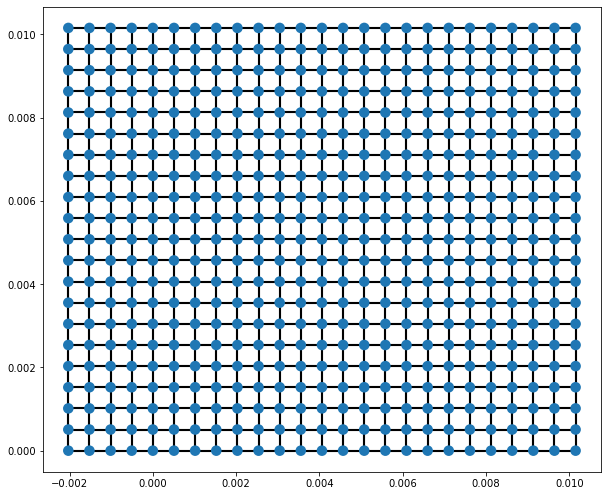

In [222]:
kwant.plot(params.system,fig_size=(10,10))

In [133]:
params.disorder

{}

In [98]:
params.energy_kz()

In [99]:
params.Fermi_dist()

In [100]:
params.F_D

[]

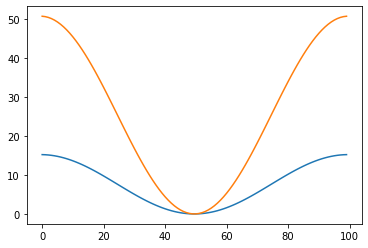

In [92]:
plt.plot(params.energy_Al)
plt.plot(params.energy_FM)

In [93]:
params.kz_list

array([-6127.21971445, -6003.43749799, -5879.65528154, -5755.87306509,
       -5632.09084863, -5508.30863218, -5384.52641573, -5260.74419927,
       -5136.96198282, -5013.17976637, -4889.39754991, -4765.61533346,
       -4641.83311701, -4518.05090055, -4394.2686841 , -4270.48646765,
       -4146.70425119, -4022.92203474, -3899.13981829, -3775.35760183,
       -3651.57538538, -3527.79316892, -3404.01095247, -3280.22873602,
       -3156.44651956, -3032.66430311, -2908.88208666, -2785.0998702 ,
       -2661.31765375, -2537.5354373 , -2413.75322084, -2289.97100439,
       -2166.18878794, -2042.40657148, -1918.62435503, -1794.84213858,
       -1671.05992212, -1547.27770567, -1423.49548922, -1299.71327276,
       -1175.93105631, -1052.14883985,  -928.3666234 ,  -804.58440695,
        -680.80219049,  -557.01997404,  -433.23775759,  -309.45554113,
        -185.67332468,   -61.89110823,    61.89110823,   185.67332468,
         309.45554113,   433.23775759,   557.01997404,   680.80219049,
      

In [94]:
params.estimate_eig()

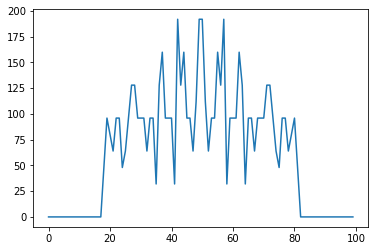

In [95]:
plt.plot(params.estimate)

In [54]:
zz={}
for i in range(2):
    zz[i]=np.arange(2)

In [57]:
np.meshgrid(*zz)

[array([[0]]), array([[1]])]

In [14]:
assert False,"error"

AssertionError: error

In [15]:
class Params:
    '''
    generate bilayer hetereostructure
    example: params=Params(g=1,ED=433)
    
    '''
    def __init__(self,
        a=np.array([0.1,0.1,0.1]), # lattice constant (nm)
        L_Al=np.array([10,10,5]),   # size of Al (nm)
        L_FM=np.array([2,10,5]), # size of FM (nm)
        m_Al=1,    # m_e, where m_e is 0.511 MeV
        m_FM=1,
        EF_Al=11, # Chemical potential of Al in eV
        EF_FM=-0.5,
        h_exc=0,  # exchange field in eV, acts like Zeeman field
        g=5.6,   # Coupling strength in eV
        E_D=1,    # Debye temperature in 433 K
        T=0,    # Temperature in eV      
        U_D=0,     # variance of disorder in eV
        periodic_boundary_condition=1, # 1: periodic boundary condition
        verbose=True   #verbose
        ):
        assert L_Al[1]==L_FM[1],"The y dimension of Al ({}) not same as FM ({})".format(L_Al[1],L_FM[1])

        self.a=np.array(a)*1e-9*5.076e6    # eV^-1
        self.L_Al=np.array(L_Al)*1e-9*5.076e6    # eV^-1
        self.L_FM=np.array(L_FM)*1e-9*5.076e6   # eV^-1
        self.m_Al=m_Al*0.511e6    # eV
        self.m_FM=m_FM*0.511e6    # eV
        self.EF_Al=EF_Al        # eV
        self.EF_FM=EF_FM        # eV
        self.h_exc=h_exc        # eV
        self.g=g            # eV
        self.E_D=E_D*433*8.617333262e-5       # eV
        self.T=T            # eV
        self.U_D=U_D  # eV
        self.periodic_boundary_condition=periodic_boundary_condition
        self.verbose=verbose


        # self.N=np.rint(self.L/self.a).astype(int)    # Number of grids in the real-sapce mesh
        self.s0=np.array([[1,0],[0,1]])
        self.sx=np.array([[0,1],[1,0]])
        self.sy=np.array([[0,-1j],[1j,0]])
        self.sz=np.array([[1,0],[0,-1]])
        self.b=2*np.pi/self.a    # reciprocal unit vector in eV
        self.t_Al=1/(2*self.m_Al*self.a**2)    # NN hopping of Al in eV
        self.t_FM=1/(2*self.m_FM*self.a**2)    # NN hopping of FM in eV
        self.m_int=np.sqrt(m_Al*m_FM)
        self.t_int=1/(2*self.m_int*self.a**2)    # NN hopping at the interface in eV

        # self.disorder=np.random.uniform(-U_D,U_D,())
        
        # self.variance*np.random.randn(self.N[0],self.N[1])    # disorder profile
        # self.Delta=np.zeros((self.N[0],self.N[1]))  
        # self.wfall=[[] for _ in range(self.N[2])]
        # self.energyall=[[] for _ in range(self.N[2])]    
        self.wfall=[]
        self.energyall=[]


    def energy_kz(self):
        kindex=np.arange(self.N[2])
        uz=(2*kindex-self.N[2]+1)/(2*self.N[2])
        self.kzlist=uz*self.b[2]    # eV^-1
        self.energy_Al=2*self.t[2]*(1-np.cos(self.a[2]*self.kzlist))   # eV
        return self.energylist
    
    def estimate_k(self):
        k_request=np.zeros(self.N[2])
        for kzindex in range(self.N[2]):
            kxindex=np.arange(self.N[0])
            kyindex=np.arange(self.N[1])        
            ux=(2*kxindex-self.N[0]+1)/(2*self.N[0])
            uy=(2*kyindex-self.N[1]+1)/(2*self.N[1])
            kxlist=ux*self.b[0]
            kylist=uy*self.b[1]
            kz=self.kzlist[kzindex]
            [kxgrid,kygrid]=np.meshgrid(kxlist,kylist)
            Emesh=2*self.t[0]*(1-np.cos(kxgrid*self.a[0]))\
                +2*self.t[1]*(1-np.cos(kygrid*self.a[1]))\
                +2*self.t[2]*(1-np.cos(kz*self.a[2]))-self.E_F
            k_request[kzindex]=4*np.count_nonzero((Emesh<self.E_D) & (Emesh>-self.E_D))
        self.k_request=k_request.astype(int)
        return self.k_request
    
    def Fermi_dist(self):
        self.F_D=[1./(np.exp(np.array(energy)/self.T)+1) if len(energy)>0 else [] for energy in self.energyall]
        return self.F_D


ValueError: eee

In [5]:
x=np.random.rand(2000,2000)

In [3]:
x

array([[0.7797932 , 0.8953151 , 0.14383599, ..., 0.55174226, 0.67548541,
        0.09477704],
       [0.2773878 , 0.97152523, 0.86985566, ..., 0.10051182, 0.25149315,
        0.30790199],
       [0.40373666, 0.43077359, 0.79742827, ..., 0.03423884, 0.02271493,
        0.35329278],
       ...,
       [0.64202836, 0.03812078, 0.8744877 , ..., 0.11265128, 0.57538244,
        0.86400314],
       [0.27630545, 0.29227187, 0.91278394, ..., 0.27754341, 0.73006839,
        0.93438926],
       [0.60856454, 0.89767812, 0.55927873, ..., 0.53628964, 0.73030519,
        0.97242069]])

In [7]:
import scipy.linalg as la

In [ ]:
la.eigvals()

In [11]:
st=time.time()
la.eig(x)
print(time.time()-st)

4.997797250747681


In [97]:
p=Params(L=[25e-10,25e-10,50e-10],E_D=50*433,periodic_boundary_condition=0)
p.energy_kz()
p.estimate_k()

iter(2e-2,p)

kindex=6,min(val)=1.905,max(val)=2.720,
len(val)=0
kindex=7,min(val)=1.170,max(val)=1.985,
len(val)=32
kindex=8,min(val)=0.365,max(val)=2.092,
len(val)=76
kindex=9,min(val)=0.063,max(val)=2.443,
len(val)=120
kindex=10,min(val)=0.053,max(val)=1.985,
len(val)=172
kindex=11,min(val)=0.053,max(val)=2.012,
len(val)=208
kindex=12,min(val)=0.031,max(val)=1.840,
k (218) is too small, restart with k (436)
len(val)=224
kindex=13,min(val)=0.073,max(val)=1.953,
len(val)=228
kindex=14,min(val)=0.104,max(val)=1.880,
len(val)=244
kindex=15,min(val)=0.050,max(val)=2.050,
len(val)=248
kindex=16,min(val)=0.061,max(val)=1.941,
len(val)=248
kindex=17,min(val)=0.057,max(val)=1.935,
len(val)=264
kindex=18,min(val)=0.025,max(val)=1.817,
k (284) is too small, restart with k (568)
len(val)=288
kindex=19,min(val)=0.027,max(val)=1.911,
len(val)=304
kindex=20,min(val)=0.024,max(val)=1.815,
k (318) is too small, restart with k (636)
len(val)=332
kindex=21,min(val)=0.021,max(val)=1.718,
k (318) is too small, restar

KeyboardInterrupt: 

In [32]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '0.013720508545789972')

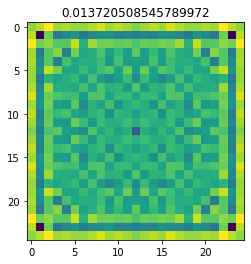

In [98]:
fig,ax=plt.subplots()
ax.imshow(p.Delta)
ax.set_title(p.Delta.mean())